In [1]:
### Merge wind 1-min files
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import math
import cftime
import sys
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
# from read_topo import load_topo_arctic_HiRes, load_topo_arctic
from convert_time import datetime_to_yearday
# Importing saildrone data:
year = '2022'
platf_num = '1031'
path = os.path.expanduser('~/Documents/Data/Hurricane'+year+'/delayed/'+platf_num+'/')
outpath = path+'merged_files/'
filenames = np.sort( os.listdir(path) ); print('has',len(filenames),'files in the directory')
filenames = [x for x in filenames if ".nc" in x]; print('has',len(filenames),'nc files')
pathout = os.getcwd()+'/fig_'+platf_num+'/'
print(pathout)
if os.path.isdir(pathout):
    pass
else:
    os.mkdir(pathout)
### the list of variables I want
# vars_yes = ['UWND_MEAN','UWND_STDDEV','VWND_MEAN','VWND_STDDEV','GUST_WND_MEAN','GUST_WND_STDDEV','WIND_MEASUREMENT_HEIGHT_MEAN',\
#             'latitude','longitude','time']
vars_yes = ['latitude','longitude','time','UWND_MEAN','UWND_STDDEV','VWND_MEAN','VWND_STDDEV','GUST_WND_MEAN','GUST_WND_STDDEV',\
            'WIND_MEASUREMENT_HEIGHT_MEAN','TEMP_AIR_MEAN','RH_MEAN','BARO_PRES_MEAN','PAR_AIR_MEAN',\
                'WAVE_DOMINANT_PERIOD','WAVE_SIGNIFICANT_HEIGHT',\
                    'TEMP_DEPTH_HALFMETER_MEAN','TEMP_SBE37_MEAN','TEMP_SBE37_STDDEV','SAL_SBE37_MEAN','SAL_SBE37_STDDEV',\
                        'WATER_CURRENT_SPEED_MEAN','WATER_CURRENT_DIRECTION_MEAN']

has 1286 files in the directory
has 1285 nc files
/Users/chi/Documents/projects/sd-windpower/plot_SD/fig_1031/


In [35]:
### create a dictionary
vars_dic = {}
ds = nc.Dataset(path+'/'+filenames[0])
# nz = len( ds.variables['cell_depth'][:] )
varnms = list( ds.variables.keys() )
### add empty items to the dictionary 
for i in range( len(varnms) ):
    vkey = varnms[i]
    if vkey in vars_yes:
        item = ds.variables[vkey][:]
        vars_dic[vkey] = np.empty( item.shape )
        # print(vkey, item.shape, vars_dic[vkey].shape)
print(len(varnms),'variables in nc file &', len(vars_dic),'variables are selected to append')
### go through each daily nc file & append the selected variables 
for f in range( len(filenames) ):
    fsize = os.stat(path+'/'+filenames[f]).st_size/1000 # kb
    if fsize > 400:
        ds = nc.Dataset(path+'/'+filenames[f])
        for i in range( len(varnms) ):
            vkey = varnms[i]
            if (vkey in vars_yes): #& (vkey not in vars_nostack):
                # print(vkey)
                vkey = varnms[i]
                item_old = vars_dic[vkey]
                item_app = np.squeeze( ds.variables[vkey][:] )
                ### append in time dimension only
                if f == 0:
                    vars_dic[vkey] = item_app
                else:
                    vars_dic[vkey] = np.concatenate( (item_old, item_app),axis=0 )
        print('Done',filenames[f])
    else:
        print(filenames[f],'filesize too small. skipped')

77 variables in nc file & 10 variables are selected to append
Done saildrone-gen_6-hurricane_monitoring_2022-sd1031-20220715T200000-20220715T215959-1_minutes-v1.1658010635687.nc
Done saildrone-gen_6-hurricane_monitoring_2022-sd1031-20220715T220000-20220715T235959-1_minutes-v1.1658017880133.nc
Done saildrone-gen_6-hurricane_monitoring_2022-sd1031-20220716T000000-20220716T015959-1_minutes-v1.1658025018031.nc
Done saildrone-gen_6-hurricane_monitoring_2022-sd1031-20220716T020000-20220716T035959-1_minutes-v1.1658032228459.nc
Done saildrone-gen_6-hurricane_monitoring_2022-sd1031-20220716T040000-20220716T055959-1_minutes-v1.1658039480901.nc
Done saildrone-gen_6-hurricane_monitoring_2022-sd1031-20220716T060000-20220716T075959-1_minutes-v1.1658046609972.nc
Done saildrone-gen_6-hurricane_monitoring_2022-sd1031-20220716T080000-20220716T095959-1_minutes-v1.1658053904633.nc
Done saildrone-gen_6-hurricane_monitoring_2022-sd1031-20220716T100000-20220716T115959-1_minutes-v1.1658061026234.nc
Done saild

min time difference= 60.0 sec
1st & last time in file: 07/15 20:00Z 10/30 21:59Z
4 time gaps that are > 30 min
The corresponding time gaps (in mins) [601. 121. 121. 241.]
10/16 23:59Z - 10/17 10:00Z
10/19 01:59Z - 10/19 04:00Z
10/19 07:59Z - 10/19 10:00Z
10/19 11:59Z - 10/19 16:00Z


Text(0.5, 0.98, 'Time intervals (t(i+1)-t(i)): Hurricane 2022 - 1031')

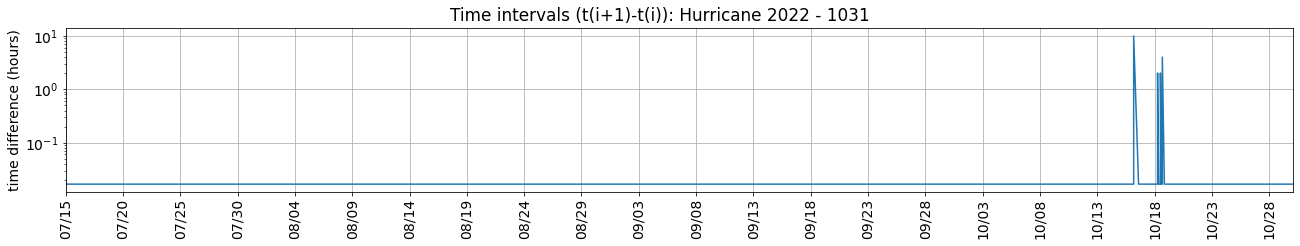

In [44]:
### plot time intervals (time(i+1)-time(i)) and print time gaps
fig, axes = plt.subplots(1)
fig.set_size_inches(22,3)
test = vars_dic['time']
dtime = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds= vars_dic['time'][i]) for i in range(len(vars_dic['time']))])
dtest = np.array([(test[i+1]-test[i])/3600 for i in range( len(test)-1 )]) # 
plt.semilogy(dtime[:-1],dtest)
ddays = (np.max(dtime)-np.min(dtime)).days
xticks = [np.min(dtime)+datetime.timedelta(days=5*i) for i in range(ddays)]
xtickslabel = [xticks[i].strftime('%m/%d') for i in range(ddays)]
plt.xticks(xticks)
plt.gca().set_xticklabels(xtickslabel, rotation=90)
plt.ylabel('time difference (hours)')
plt.xlim([dtime[0],dtime[-1]])
plt.grid()
print('min time difference=',np.min(dtest)*3600,'sec')
print('1st & last time in file:',dtime[0].strftime('%m/%d %H:%MZ'),dtime[-1].strftime('%m/%d %H:%MZ'))
### find data gaps
d5min = (datetime.datetime(2019,1,1,0,5,0)-datetime.datetime(2019,1,1)).total_seconds()/3600
d10min = (datetime.datetime(2019,1,1,0,10,0)-datetime.datetime(2019,1,1)).total_seconds()/3600
d30min = (datetime.datetime(2019,1,1,0,30,0)-datetime.datetime(2019,1,1)).total_seconds()/3600
d60min = (datetime.datetime(2019,1,1,1,0,0)-datetime.datetime(2019,1,1)).total_seconds()/3600
i_tgap = np.where( dtest > d30min )[0]
print(len(i_tgap),'time gaps that are > 30 min')
print('The corresponding time gaps (in mins)',dtest[i_tgap]*60)
for i in range( len(i_tgap) ):
    print(dtime[i_tgap[i]].strftime('%m/%d %H:%MZ'),'-',dtime[i_tgap[i]+1].strftime('%m/%d %H:%MZ'))

plt.suptitle('Time intervals (t(i+1)-t(i)): Hurricane '+year+' - '+platf_num)
### save figure
# fig.savefig(pathout+'time_intervals_'+year+'-'+platf_num+'.png', dpi=300,bbox_inches='tight')

['UWND_MEAN', 'UWND_STDDEV', 'VWND_MEAN', 'VWND_STDDEV', 'GUST_WND_MEAN', 'GUST_WND_STDDEV', 'WIND_MEASUREMENT_HEIGHT_MEAN', 'latitude', 'longitude', 'time']
latitude


/var/folders/hq/8x0c_cvs4651pwh9kv6t7_zc0000gq/T/ipykernel_62199/320169194.py:19: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(h,labels=[vkey],loc='upper left')


longitude
UWND_MEAN
UWND_STDDEV
VWND_MEAN
VWND_STDDEV
GUST_WND_MEAN
GUST_WND_STDDEV
WIND_MEASUREMENT_HEIGHT_MEAN


<Figure size 432x288 with 0 Axes>

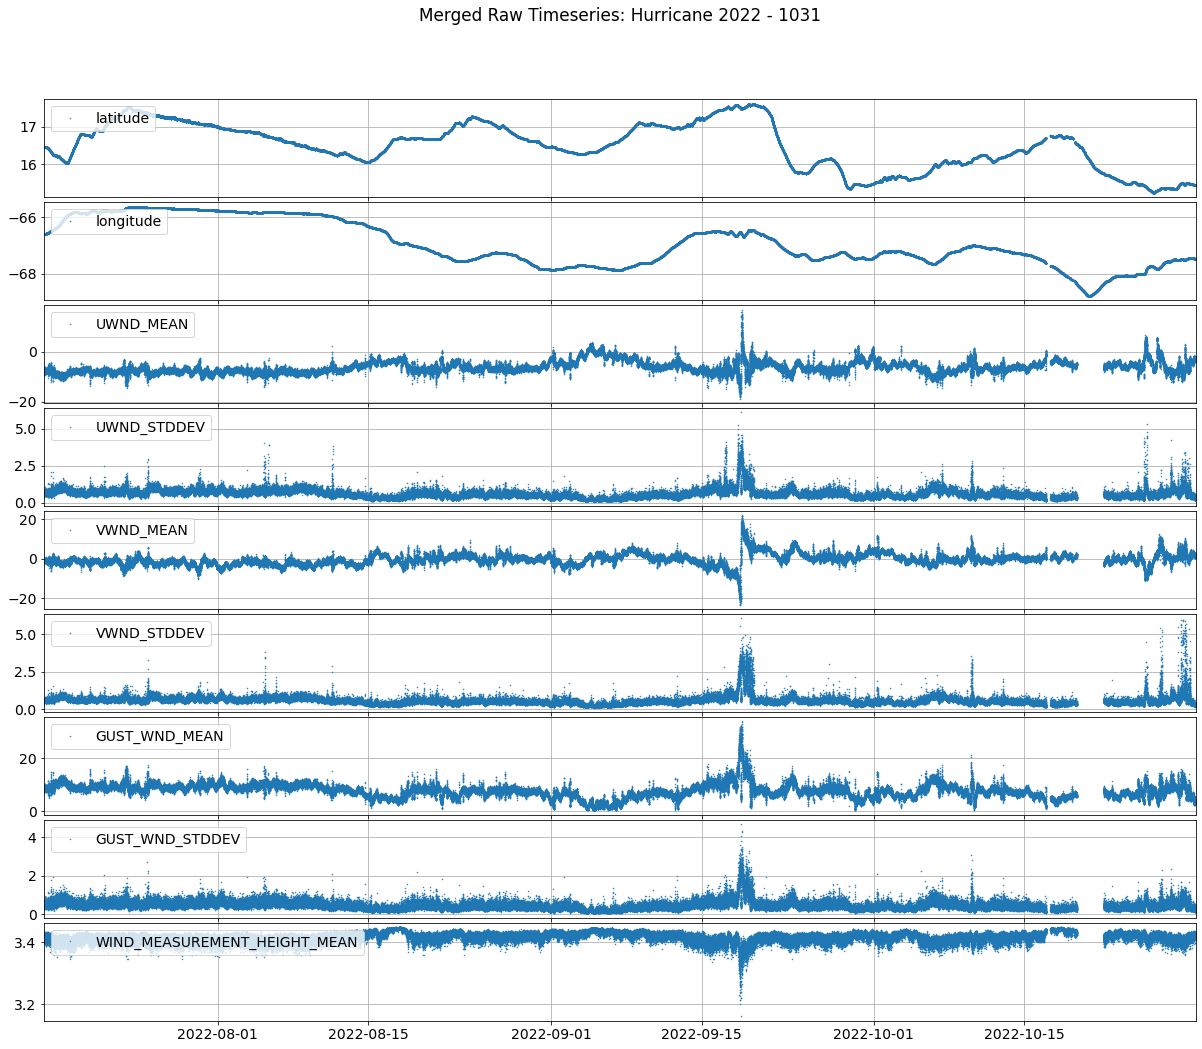

In [52]:
### plot merged raw data (1D data)
print(list(vars_dic.keys()))
vars_plot = ['latitude','longitude','UWND_MEAN','UWND_STDDEV','VWND_MEAN','VWND_STDDEV','GUST_WND_MEAN','GUST_WND_STDDEV','WIND_MEASUREMENT_HEIGHT_MEAN']
nrow = len(vars_plot)
tlim = [dtime[0],dtime[-1]]
### initiate plot
plt.clf()
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(nrow,1)
fig.set_size_inches(20,16)
for i in range( nrow ):
    vkey = vars_plot[i]
    print(vkey)
    data = vars_dic[vkey]
    h = plt.subplot(nrow,1,i+1)
    plt.plot(dtime,data,'.',ms=1)
    plt.xlim(tlim)
    plt.grid()
    plt.legend(h,labels=[vkey],loc='upper left')
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.05)
plt.suptitle('Merged Raw Timeseries: Hurricane '+year+' - '+platf_num)
fig.savefig(pathout+'merge_raw_1D_'+year+'-'+platf_num+'.png', dpi=300,bbox_inches='tight')

In [60]:
### write the merged data to netcdf file: https://unidata.github.io/python-training/workshop/Bonus/netcdf-writing/
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
# ncfile = nc.Dataset('wind-1min-merge-'+year+'-SD'+platf_num+'.nc',mode='w',format='NETCDF4_CLASSIC') 
ncfile = nc.Dataset('airsea-1min-merge-'+year+'-SD'+platf_num+'.nc',mode='w',format='NETCDF4_CLASSIC') 
print(ncfile)
### creating dimensions
time_dim = ncfile.createDimension('time', len(dtime)) # unlimited axis (can be appended to).
for dim in ncfile.dimensions.items():
    print(dim)
### creating attributes
ncfile.title='Merged files for SD-'+platf_num
print(ncfile.title)
ncfile.subtitle="Only selected variables for wind measurements are here. Temporal resolution is 1-minute."
print(ncfile.subtitle)
print(ncfile)
### move the writing data to new variables
### compute the time as seconds since 2022-01-01
time_out = np.array([(dtime[i]-datetime.datetime(int(year),1,1)).total_seconds() for i in range(len(dtime))])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 
('time', <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 153120)
Merged files for SD-1031
Only selected variables for wind measurements are here. Temporal resolution is 1-minute.
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for SD-1031
    subtitle: Only selected variables for wind measurements are here. Temporal resolution is 1-minute.
    dimensions(sizes): time(153120)
    variables(dimensions): 
    groups: 


In [61]:
### Creating variables: 'UWND_MEAN', 'UWND_STDDEV', 'VWND_MEAN', 'VWND_STDDEV', 'GUST_WND_MEAN', 'GUST_WND_STDDEV', 'WIND_MEASUREMENT_HEIGHT_MEAN'
time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'seconds since '+year+'-01-01'
time.long_name = 'time'
longitude = ncfile.createVariable('longitude', np.float64, ('time',))
longitude.units = 'degrees_east'
longitude.long_name = 'longitude'
latitude = ncfile.createVariable('latitude', np.float64, ('time',))
latitude.units = 'degrees_north'
latitude.long_name = 'latitude'
UWND_MEAN = ncfile.createVariable('UWND_MEAN', np.float64, ('time',))
UWND_MEAN.units = 'm s-1'
UWND_MEAN.long_name = 'Eastward wind speed'
UWND_MEAN.nominal_sampling_schedule = "60s on, 240s off, centered at :00"
VWND_MEAN = ncfile.createVariable('VWND_MEAN', np.float64, ('time',))
VWND_MEAN.units = 'm s-1'
VWND_MEAN.long_name = 'Northward wind speed'
VWND_MEAN.nominal_sampling_schedule = "60s on, 240s off, centered at :00"
GUST_WND_MEAN = ncfile.createVariable('GUST_WND_MEAN', np.float64, ('time',))
GUST_WND_MEAN.units = 'm s-1'
GUST_WND_MEAN.long_name = 'Wind gust speed'
GUST_WND_MEAN.nominal_sampling_schedule = "60s on, 240s off, centered at :00"
WIND_MEASUREMENT_HEIGHT_MEAN = ncfile.createVariable('WIND_MEASUREMENT_HEIGHT_MEAN', np.float64, ('time',))
WIND_MEASUREMENT_HEIGHT_MEAN.units = 'm'
WIND_MEASUREMENT_HEIGHT_MEAN.long_name = 'Wind measurement height'
WIND_MEASUREMENT_HEIGHT_MEAN.nominal_sampling_schedule = "60s on, 240s off, centered at :00"

In [62]:
### writing data
# Note: the ":" is necessary in these "write" statements
time[:] = time_out
longitude[:] = vars_dic['longitude']
latitude[:] = vars_dic['latitude']
UWND_MEAN[:] = vars_dic['UWND_MEAN']
VWND_MEAN[:] = vars_dic['VWND_MEAN']
GUST_WND_MEAN[:] = vars_dic['GUST_WND_MEAN']
WIND_MEASUREMENT_HEIGHT_MEAN[:] = vars_dic['WIND_MEASUREMENT_HEIGHT_MEAN']
print(ncfile)
# close the Dataset.
ncfile.close(); print('Dataset is closed!')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for SD-1031
    subtitle: Only selected variables for wind measurements are here. Temporal resolution is 1-minute.
    dimensions(sizes): time(153120)
    variables(dimensions): float64 time(time), float64 longitude(time), float64 latitude(time), float64 UWND_MEAN(time), float64 VWND_MEAN(time), float64 GUST_WND_MEAN(time), float64 WIND_MEASUREMENT_HEIGHT_MEAN(time)
    groups: 
Dataset is closed!
